<a href="https://colab.research.google.com/github/tankchirag/Car-Binary-classification/blob/main/Copy_of_UIUC_car_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setting Up Environment

In [ ]:
!pip install numpy pandas matplotlib tensorflow scikit-learn

2. Download and extract dataset

In [ ]:
!wget -O CarData.tar.gz 'https://raw.githubusercontent.com/gcr/arc-evaluator/a7ec771f3b601c4e5a2e885e58efd31dbf37a1fe/CarData.tar.gz'
!tar -xvzf CarData.tar.gz

--2025-01-14 20:09:25--  https://raw.githubusercontent.com/gcr/arc-evaluator/a7ec771f3b601c4e5a2e885e58efd31dbf37a1fe/CarData.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7297444 (7.0M) [application/octet-stream]
Saving to: ‘CarData.tar.gz’

CarData.tar.gz      100%[===================>]   6.96M  --.-KB/s    in 0.07s   

2025-01-14 20:09:26 (106 MB/s) - ‘CarData.tar.gz’ saved [7297444/7297444]

CarData/Evaluator.class
CarData/Evaluator.java
CarData/Evaluator_Scale.class
CarData/Evaluator_Scale.java
CarData/Point.class
CarData/Point_Scale.class
CarData/README.txt
CarData/TestImages/
CarData/TestImages/test-0.pgm
CarData/TestImages/test-1.pgm
CarData/TestImages/test-10.pgm
CarData/TestImages/test-100.pgm
CarData/TestImages/test-101.pgm
CarData/TestIm

3. Load and Explore the Data

3.1 Loading Training Data

In [ ]:
import os
import cv2
import numpy as np

# Paths to training data
train_dir = "CarData/TrainImages"

# Function to load images and labels
def load_train_data(train_dir):
    images = []
    labels = []
    for img_file in os.listdir(train_dir):
        if img_file.startswith("pos-"):
            label = 1  # Positive class (car)
        elif img_file.startswith("neg-"):
            label = 0  # Negative class (non-car)
        else:
            continue  # Skip files that don't match the pattern

        img_path = os.path.join(train_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_train_data(train_dir)

# Check data shape
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")

Training Data Shape: (1050, 40, 100)
Training Labels Shape: (1050,)


3.2 Loading Testing Data

In [ ]:
# Path to test data
test_dir = "CarData/TestImages"

# Function to load and resize test images
def load_test_data(test_dir):
    images = []
    for img_file in sorted(os.listdir(test_dir)):  # Sorting ensures correct order
        img_path = os.path.join(test_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (100, 40))  # Resize to match training dimensions
        images.append(img_resized)
    return np.array(images)

X_test = load_test_data(test_dir)

# Load ground truth locations for evaluation
true_locations = []
with open("CarData/trueLocations.txt", "r") as f:
    for line in f:
        true_locations.append(line.strip())

# Check data shape
print(f"Test Data Shape: {X_test.shape}")
print(f"Number of Test Images: {len(true_locations)}")


Test Data Shape: (170, 40, 100)
Number of Test Images: 170


Preprocess the Data

Normalization: Normalize pixel values to the range [0, 1]:

Reshape: Ensure the data is in the required shape (e.g., (samples, height, width, channels) for CNNs):

In [ ]:
# Normalize the images to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape for CNN (add channel dimension)
X_train = X_train.reshape(-1, 40, 100, 1)
X_test = X_test.reshape(-1, 40, 100, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train_split.shape}, Validation set shape: {X_val_split.shape}")


Training set shape: (840, 40, 100, 1), Validation set shape: (210, 40, 100, 1)


Build and Train the CNN:

A binary classifier for car vs. non-car detection.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15, batch_size=32,
    validation_split=0.2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.6019 - loss: 0.6756 - val_accuracy: 0.9762 - val_loss: 0.1639
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9596 - loss: 0.1510 - val_accuracy: 0.9810 - val_loss: 0.0625
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.9769 - loss: 0.0657 - val_accuracy: 0.9381 - val_loss: 0.1498
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.9708 - loss: 0.0774 - val_accuracy: 0.9952 - val_loss: 0.0346
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9888 - loss: 0.0394 - val_accuracy: 0.9857 - val_loss: 0.0495
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.9852 - loss: 0.0508 - val_accuracy: 0.9905 - val_loss: 0.0375
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.9952 - val_loss: 0.0230
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0

 Plot Loss and Accuracy Curves

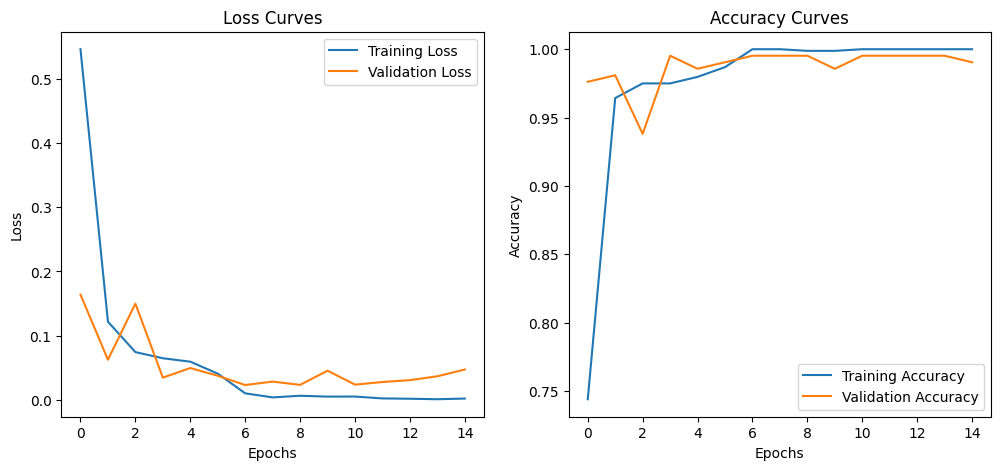

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Evaluate the Model

 Inference on Test Data

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


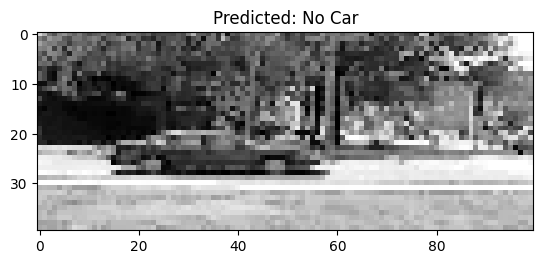

In [ ]:
# Predict on test data
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Visualize one test image with its prediction
plt.imshow(X_test[0].reshape(40, 100), cmap='gray')
plt.title(f"Predicted: {'Car' if predicted_labels[0] == 1 else 'No Car'}")
plt.show()


Inference on Multiple Test Images

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the entire test dataset
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Compare with ground truth
true_labels = y_test

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Detailed evaluation report
report = classification_report(true_labels, predicted_labels, target_names=["No Car", "Car"])
print("\nClassification Report:")
print(report)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


NameError: name 'y_test' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load ground truth labels for the test set (replace with your actual loading logic)
# Example using trueLocations.txt (adapt to your label format)
true_labels = []
with open("CarData/trueLocations.txt", "r") as f:
    for line in f:
        # Assuming label is 1 if a location is present, 0 otherwise
        true_labels.append(1)  # Adjust if your format is different

# If using a separate test set with labels:
# true_labels = y_test  # Where y_test contains the actual ground truth labels

# ... rest of your code ...

# Predict on the entire test dataset
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Compare with ground truth
# true_labels = y_test  # This line is likely causing the issue

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Detailed evaluation report
report = classification_report(true_labels, predicted_labels, target_names=["No Car", "Car"])
print("\nClassification Report:")
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Confusion Matrix:
[[  0   0]
 [170   0]]

Classification Report:
              precision    recall  f1-score   support

      No Car       0.00      0.00      0.00       0.0
         Car       0.00      0.00      0.00     170.0

    accuracy                           0.00     170.0
   macro avg       0.00      0.00      0.00     170.0
weighted avg       0.00      0.00      0.00     170.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Confusion Matrix:
[[  0   0]
 [170   0]]

Classification Report:
              precision    recall  f1-score   support

      No Car       0.00      0.00      0.00       0.0
         Car       0.00      0.00      0.00     170.0

    accuracy                           0.00     170.0
   macro avg       0.00      0.00      0.00     170.0
weighted avg       0.00      0.00      0.00     170.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

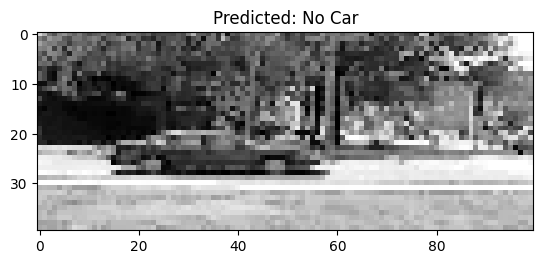

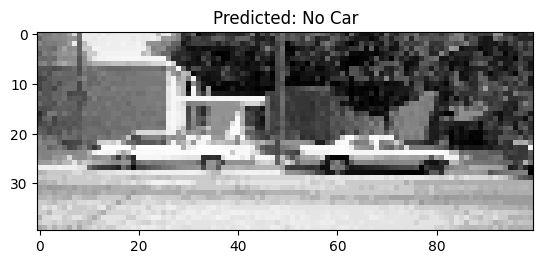

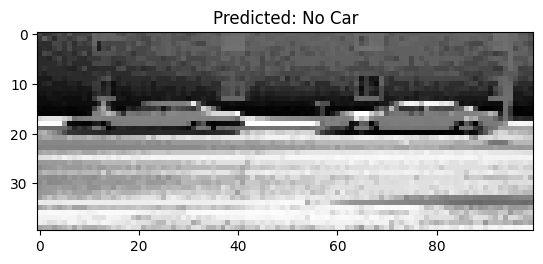

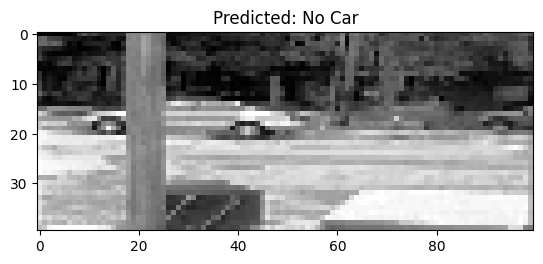

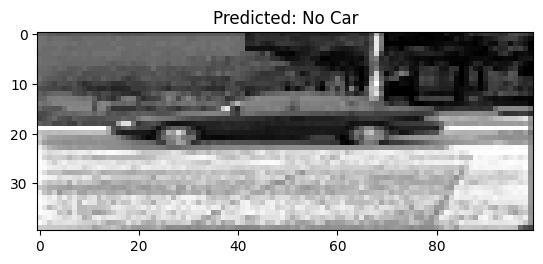

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# ... (Load your model and test data - X_test - as before) ...

# 1. Load ground truth labels (assuming all images in trueLocations.txt have cars):
true_labels = []
with open("CarData/trueLocations.txt", "r") as f:
    for line in f:
        true_labels.append(1)  # Assuming label is 1 for car

# If you have a separate test set with labels (e.g., y_test):
# true_labels = y_test

# 2. Make predictions:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)  # Convert to 0 or 1

# 3. Reshape predicted_labels to match true_labels if necessary:
predicted_labels = predicted_labels.reshape(-1)  # Flatten to 1D array

# 4. Generate confusion matrix:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# 5. Generate classification report:
report = classification_report(true_labels, predicted_labels, target_names=["No Car", "Car"])
print("\nClassification Report:")
print(report)

# 6. Display predictions for a few images (optional):
import matplotlib.pyplot as plt
num_images_to_display = 5  # Adjust as needed
for i in range(num_images_to_display):
    plt.imshow(X_test[i].reshape(40, 100), cmap='gray')
    plt.title(f"Predicted: {'Car' if predicted_labels[i] == 1 else 'No Car'}")
    plt.show()

IndexError: invalid index to scalar variable.

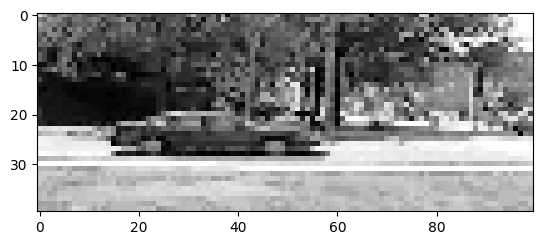

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display (adjust as needed)
num_images_to_display = 5

# Loop through the desired number of images
for i in range(num_images_to_display):
    # Display the image
    plt.imshow(X_test[i].reshape(40, 100), cmap='gray')

    # Get the predicted label for the current image
    predicted_label = predicted_labels[i][0]  # Access the label from the array

    # Set the title with the prediction
    plt.title(f"Predicted: {'Car' if predicted_label == 1 else 'No Car'}")

    # Show the plot for the current image
    plt.show()

In [ ]:
# Predict on test images
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Placeholder for found locations (to integrate evaluator functionality)
found_locations = []

# Example for generating output similar to `trueLocations.txt`
for idx, pred in enumerate(predicted_labels):
    if pred == 1:
        # Example location (assume top-left corner as dummy)
        found_locations.append(f"{idx}: (0,0)")

# Write predictions to file
with open("foundLocations.txt", "w") as f:
    f.write("\n".join(found_locations))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluate with Evaluator

In [ ]:
# Run evaluator
!java -classpath CarData Evaluator trueLocations.txt foundLocations.txt


IO Exception
Exception in thread "main" java.lang.NullPointerException
	at java.base/java.util.StringTokenizer.<init>(StringTokenizer.java:199)
	at java.base/java.util.StringTokenizer.<init>(StringTokenizer.java:221)
	at Evaluator.getLocations(Evaluator.java:91)
	at Evaluator.main(Evaluator.java:56)


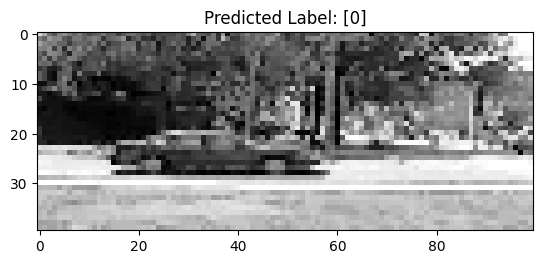

In [ ]:
import matplotlib.pyplot as plt

# Visualize one test image with predictions
plt.imshow(X_test[0].reshape(40, 100), cmap='gray')
plt.title("Predicted Label: " + str(predicted_labels[0]))
plt.show()


Multi-Scale Evaluation

In [ ]:
# Path to multi-scale test data
test_scale_dir = "CarData/TestImages_Scale"

# Load multi-scale test images
X_test_scale = load_test_data(test_scale_dir)

# Load ground truth locations for multi-scale evaluation
true_locations_scale = []
with open("CarData/trueLocations_Scale.txt", "r") as f:
    for line in f:
        true_locations_scale.append(line.strip())

print(f"Multi-Scale Test Data Shape: {X_test_scale.shape}")
print(f"Number of Multi-Scale Test Images: {len(true_locations_scale)}")


Multi-Scale Test Data Shape: (108, 40, 100)
Number of Multi-Scale Test Images: 109


In [ ]:
# Run evaluator for multi-scale
!java -classpath CarData Evaluator_Scale trueLocations_Scale.txt foundLocations_Scale.txt


IO Exception
IO Exception

Correct detections :  0 out of 0  (Recall: NaN %)
False detections   :  0           (Precision: NaN %)

F-measure :  NaN %



Resize Images Dynamically: Ensure predictions are made at various scales.
Adjust Prediction Algorithm: Handle bounding boxes dynamically for scaled test images.

In [ ]:
# Function to dynamically resize and predict on multi-scale images
def predict_multiscale(test_dir):
    results = []
    for img_file in sorted(os.listdir(test_dir)):
        img_path = os.path.join(test_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Predict at original and resized scales
        scales = [1.0, 0.75, 0.5]  # Example scales
        for scale in scales:
            resized_img = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
            resized_img = resized_img / 255.0
            resized_img = resized_img.reshape(1, resized_img.shape[0], resized_img.shape[1], 1)

            pred = model.predict(resized_img)
            if pred > 0.5:
                results.append(f"{img_file} at scale {scale}: Car detected")
    return results

multi_scale_results = predict_multiscale("CarData/TestImages_Scale")
for result in multi_scale_results:
    print(result)


InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/flatten_2_1/Reshape defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-a36dd9b69ce2>", line 20, in <cell line: 20>

  File "<ipython-input-23-a36dd9b69ce2>", line 15, in predict_multiscale

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_2_1/flatten_2_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_17922]